# Markov regime switch model of T-bill yields to yield curve

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load data

In [2]:
from statsmodels.multivariate.pca import PCA

#df = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/Fama-Bliss Discount Bond Yields.dta')
#pc = PCA(df.loc[:,'yield2':'yield5'])

df = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Gurkaynak, Sack, Wright. 2006. The U.S. Treasury Yield Curve 1961 to the Present/zero_coupon_yields_monthly_end.dta')
df = df.iloc[:,[0,1,2,3,4,5,7,10,15]]
df = df.dropna(how='any').reset_index(drop=True)

df.head()

,date,sveny01,sveny02,sveny03,sveny04,sveny05,sveny07,sveny10,sveny15
0,1971-11-01,4.6539,5.0616,5.3648,5.5808,5.7347,5.9295,6.0831,6.2037
1,1971-12-01,4.3542,4.7912,5.1087,5.3434,5.5200,5.7610,5.9677,6.1382
2,1972-01-01,4.2430,4.9197,5.3311,5.5942,5.7710,5.9864,6.1531,6.2835
3,1972-02-01,4.2036,4.8476,5.2582,5.5306,5.7185,5.9528,6.1372,6.2823
4,1972-03-01,5.0208,5.5715,5.8148,5.9438,6.0221,6.1118,6.1792,6.2315


Compute principal components from T-bond yields

In [3]:
#pc = PCA(df.iloc[:,1:])
pc = PCA(df.iloc[:,2:])

pc.factors.columns.values[0:3] = ['PC1', 'PC2', 'PC3']

df = pd.concat([df, pc.factors], axis=1)

df.head()

,date,sveny01,sveny02,sveny03,sveny04,sveny05,sveny07,sveny10,sveny15,PC1,PC2,PC3,comp_3,comp_4,comp_5,comp_6
0,1971-11-01,4.6539,5.0616,5.3648,5.5808,5.7347,5.9295,6.0831,6.2037,-0.005138,-0.013557,0.057661,-0.006921,0.000768,0.021253,-0.008747
1,1971-12-01,4.3542,4.7912,5.1087,5.3434,5.5200,5.7610,5.9677,6.1382,-0.007636,-0.006054,0.049153,-0.004590,0.001314,-0.002076,-0.006981
2,1972-01-01,4.2430,4.9197,5.3311,5.5942,5.7710,5.9864,6.1531,6.2835,-0.004914,-0.005097,0.073681,-0.025142,0.036014,-0.005011,-0.013419
3,1972-02-01,4.2036,4.8476,5.2582,5.5306,5.7185,5.9528,6.1372,6.2823,-0.005490,-0.002067,0.070778,-0.020753,0.026204,0.000379,-0.011675
4,1972-03-01,5.0208,5.5715,5.8148,5.9438,6.0221,6.1118,6.1792,6.2315,-0.001602,-0.033018,0.057401,-0.020833,0.049980,-0.051592,0.011609


Combine with T-bill yields

In [4]:
tbills = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Treasury Bills/yield_tbills_monthly_end.dta')

df = df.merge(tbills, on='date')

df.index = pd.PeriodIndex(df['date'], freq='M')

del df['date']

df.head()

,sveny01,sveny02,sveny03,sveny04,sveny05,sveny07,sveny10,sveny15,PC1,PC2,PC3,comp_3,comp_4,comp_5,comp_6,m1,m3,m6,y1
date,,,,,,,,,,,,,,,,,,,
1971-11,4.6539,5.0616,5.3648,5.5808,5.7347,5.9295,6.0831,6.2037,-0.005138,-0.013557,0.057661,-0.006921,0.000768,0.021253,-0.008747,NaN,4.34,4.43,4.61
1971-12,4.3542,4.7912,5.1087,5.3434,5.5200,5.7610,5.9677,6.1382,-0.007636,-0.006054,0.049153,-0.004590,0.001314,-0.002076,-0.006981,NaN,3.68,4.03,4.08
1972-01,4.2430,4.9197,5.3311,5.5942,5.7710,5.9864,6.1531,6.2835,-0.004914,-0.005097,0.073681,-0.025142,0.036014,-0.005011,-0.013419,NaN,3.35,3.73,4.03
1972-02,4.2036,4.8476,5.2582,5.5306,5.7185,5.9528,6.1372,6.2823,-0.005490,-0.002067,0.070778,-0.020753,0.026204,0.000379,-0.011675,NaN,3.46,3.78,4.18
1972-03,5.0208,5.5715,5.8148,5.9438,6.0221,6.1118,6.1792,6.2315,-0.001602,-0.033018,0.057401,-0.020833,0.049980,-0.051592,0.011609,NaN,3.83,4.39,4.80


### Simple linear regression of T-bill yields on the principal components

In [5]:
X = sm.add_constant(df.loc[:,'PC1':'PC3'])

ols = sm.OLS(df['m3'], X)

results = ols.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     m3   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     8888.
Date:                Thu, 02 Nov 2017   Prob (F-statistic):               0.00
Time:                        11:06:19   Log-Likelihood:                -388.64
No. Observations:                 552   AIC:                             785.3
Df Residuals:                     548   BIC:                             802.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7280      0.021    226.221      0.0

### Markov regimg switching model estimation

In [6]:
regime_model = sm.tsa.MarkovRegression(
    df['m3'], exog=df.loc[:,'PC1':'PC3'], k_regimes=2)

regime_results = regime_model.fit()

print(regime_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                     m3   No. Observations:                  552
Model:               MarkovRegression   Log Likelihood                -239.133
Date:                Thu, 02 Nov 2017   AIC                            500.265
Time:                        11:06:20   BIC                            547.714
Sample:                    11-30-1971   HQIC                           518.805
                         - 10-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5077      0.020    221.188      0.000       4.468       4.548
x1            72.9922      0.456    160.043      0.0

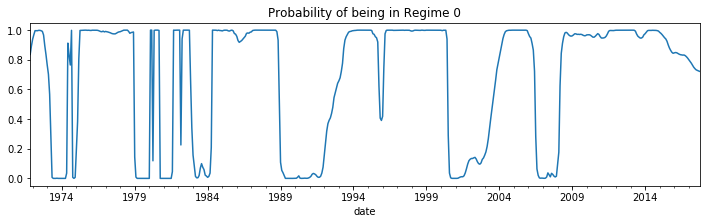

In [7]:
regime_results.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in Regime 0', figsize=(12,3));

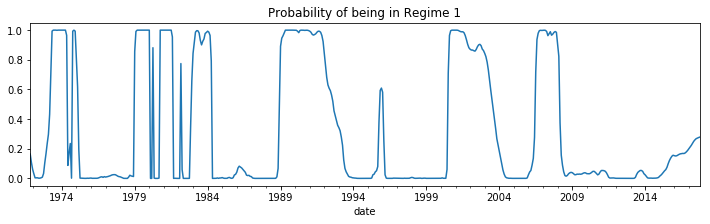

In [8]:
regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));